# Deep Learning Model

## Imports

In [10]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow import device
import gc
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [11]:
gpus = list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Importing Dataset

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'C:\\DataSet\\DL Project\\Terrain Recognition\\Data Main\\train',  
    target_size=(227, 227),      
    batch_size=16,               
    class_mode='categorical'     
)

val_generator = val_datagen.flow_from_directory(
    'C:\\DataSet\\DL Project\\Terrain Recognition\\Data Main\\val',
    target_size=(227, 227),
    batch_size=16,
    class_mode='categorical'
)

Found 31571 images belonging to 4 classes.
Found 6765 images belonging to 4 classes.


## Garbage Collection

In [13]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

## Model Creation

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dense(4, activation='softmax')
    ])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [15]:
checkpoint = ModelCheckpoint(
    'best_model_weights10.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

## Model Training Dataset

In [7]:
with device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[checkpoint, early_stopping, ClearMemory()]
    )

Epoch 1/50
1974/1974 [==============================] - 511s 249ms/step - loss: 0.6256 - accuracy: 0.7464 - val_loss: 0.6225 - val_accuracy: 0.7104
Epoch 2/50
1974/1974 [==============================] - 459s 232ms/step - loss: 0.4221 - accuracy: 0.8424 - val_loss: 0.3112 - val_accuracy: 0.8837
Epoch 3/50
1974/1974 [==============================] - 320s 162ms/step - loss: 0.3805 - accuracy: 0.8630 - val_loss: 0.3315 - val_accuracy: 0.8810
Epoch 4/50
1974/1974 [==============================] - 171s 87ms/step - loss: 0.3130 - accuracy: 0.8897 - val_loss: 0.2759 - val_accuracy: 0.9063
Epoch 5/50
1974/1974 [==============================] - 202s 102ms/step - loss: 0.2548 - accuracy: 0.9105 - val_loss: 0.2846 - val_accuracy: 0.9029
Epoch 6/50
1974/1974 [==============================] - 281s 142ms/step - loss: 0.2308 - accuracy: 0.9236 - val_loss: 0.2511 - val_accuracy: 0.9227
Epoch 7/50
1974/1974 [==============================] - 199s 101ms/step - loss: 0.2206 - accuracy: 0.9287 - val_l

## Testing Dataset 2

In [4]:
test_data_dir = 'C:\\DataSet\\DL Project\\Terrain Recognition\\Data Main\\test'
target_size = (227, 227) 
num_classes = 4           

def load_images_and_labels(data_dir, target_size, num_classes):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  
            images.append(img_array)
            labels.append(class_index)  

    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    return images, labels

## Importing saved weight values

In [5]:
model.load_weights('best_model_weights7.h5')

## Calculating Accuracy

In [7]:
X_test, y_test = load_images_and_labels(test_data_dir, target_size, num_classes)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

212/212 [==============================] - 21s 39ms/step - loss: 0.1081 - accuracy: 0.9657
Test Loss: 0.10809443145990372
Test Accuracy: 0.9657260775566101


In [6]:
X_test, y_test = load_images_and_labels(test_data_dir, target_size, num_classes)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test,y_pred))

212/212 [==============================] - 17s 34ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1824
           1       0.96      0.93      0.95      1657
           2       0.95      0.95      0.95      1644
           3       0.98      0.99      0.99      1644

    accuracy                           0.97      6769
   macro avg       0.97      0.97      0.97      6769
weighted avg       0.97      0.97      0.97      6769



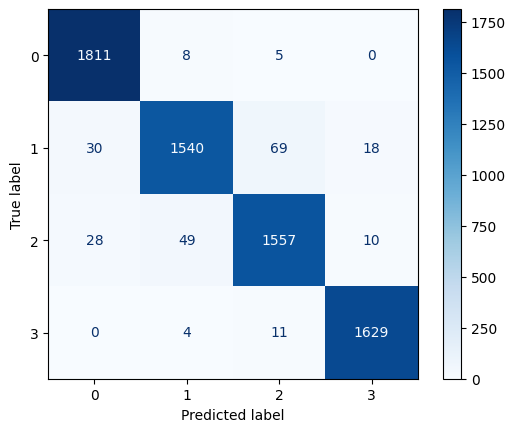

In [7]:
cm = confusion_matrix(y_test, y_pred)

display_labels = [0, 1, 2, 3]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

cm_display.plot(cmap='Blues')
plt.show()

## Testing Dataset 1

In [19]:
test_data_dir = 'C:\\DataSet\\DL Project\\Different Terrain Types Classification\\test'
target_size = (227, 227) 
num_classes = 4           

def load_images_and_labels(data_dir, target_size, num_classes):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  
            images.append(img_array)
            labels.append(class_index)  

    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)
    return images, labels

## Imorting Weight

In [20]:
model.load_weights('best_model_weights3.h5')

In [21]:
X_test, y_test = load_images_and_labels(test_data_dir, target_size, num_classes)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 8s 32ms/step - loss: 0.2979 - accuracy: 0.9104
Test Loss: 0.2978608012199402
Test Accuracy: 0.9104166626930237


In [22]:
X_test, y_test = load_images_and_labels(test_data_dir, target_size, num_classes)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test,y_pred))

15/15 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       120
           1       0.93      0.95      0.94       120
           2       0.90      0.78      0.84       120
           3       0.93      0.94      0.94       120

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480



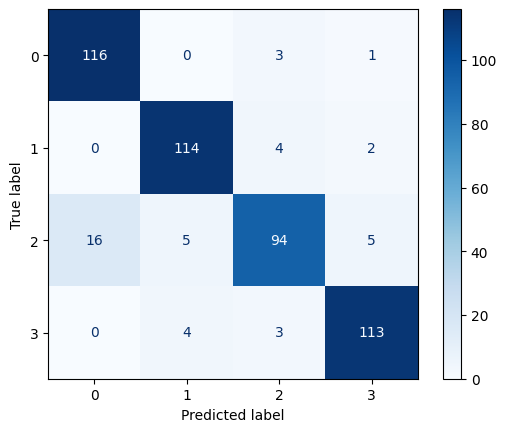

In [23]:
cm = confusion_matrix(y_test, y_pred)

display_labels = [0, 1, 2, 3]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

cm_display.plot(cmap='Blues')
plt.show()